In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/test/796707dd7.jpg
/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg
/kaggle/input/global-wheat-detection/test/51f1be19e.jpg
/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg
/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg
/kaggle/input/global-wheat-detection/test/aac893a91.jpg
/kaggle/input/global-wheat-detection/test/348a992bb.jpg
/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg
/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg
/kaggle/input/global-wheat-detection/test/53f253011.jpg
/kaggle/input/global-wheat-detection/train/4b95f5e5a.jpg
/kaggle/input/global-wheat-detection/train/59d43a53f.jpg
/kaggle/input/global-wheat-detection/train/f54dedb60.jpg
/kaggle/input/global-wheat-detection/train/efa2ec01b.jpg
/kaggle/input/global-wheat-detection/train/8a8df1c28.jpg
/kaggle/input/global-wheat-detection/train/931820

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import datasets,transforms
from glob import glob
import os
from PIL import Image
from matplotlib import patches
from torch.utils.data import Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader

In [3]:
train_dir ='/kaggle/input/global-wheat-detection/train/'
test_dir = '../input/global-wheat-detection/test/'
train = pd.read_csv('../input/global-wheat-detection/train.csv') 

In [4]:
train_images = glob(train_dir +'*')
test_images = glob(test_dir +'*')


In [5]:
train_images[:10]

['/kaggle/input/global-wheat-detection/train/4b95f5e5a.jpg',
 '/kaggle/input/global-wheat-detection/train/59d43a53f.jpg',
 '/kaggle/input/global-wheat-detection/train/f54dedb60.jpg',
 '/kaggle/input/global-wheat-detection/train/efa2ec01b.jpg',
 '/kaggle/input/global-wheat-detection/train/8a8df1c28.jpg',
 '/kaggle/input/global-wheat-detection/train/931820800.jpg',
 '/kaggle/input/global-wheat-detection/train/ea89a7320.jpg',
 '/kaggle/input/global-wheat-detection/train/aedca9e2e.jpg',
 '/kaggle/input/global-wheat-detection/train/43966050a.jpg',
 '/kaggle/input/global-wheat-detection/train/6e3da4ae3.jpg']

In [6]:
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
train['bbox'] = train['bbox'].fillna('[0,0,0,0]')
bbox_items = train['bbox'].str.split(',',expand = True)
train['x'] = bbox_items[0].str.strip('[').astype(float)
train['y'] = bbox_items[1].str.strip(' ').astype(float)
train['w'] = bbox_items[2].str.strip(' ').astype(float)
train['h'] = bbox_items[3].str.strip(']').astype(float)

In [8]:
train.head()

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [9]:
img_id = train['image_id'].unique()
valid_ids = img_id[-665:]
train_ids = img_id[:-665]

In [10]:
valid_df = train[train['image_id'].isin(valid_ids)]
train_df = train[train['image_id'].isin(train_ids)]

In [11]:
valid_df.shape,train_df.shape
train['area'] = train['w']*train['h']

In [12]:
train

,image_id,width,height,bbox,source,x,y,w,h,area
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,2016.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,7540.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,11840.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,11663.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,14508.0
...,...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0,7980.0
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0,8774.0
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0,10011.0
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0,14536.0


## Dataset Loader Class

In [13]:
class Wheatdatasets(Dataset):
    
    def __init__(self,dataframe,image_dir,transforms = None):
        
        super().__init__()
    
        self.image_id = dataframe['image_id'].unique()
        self.df = dataframe
        self.img_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self,index:int):
        
        image_id = self.image_id[index]
        record = self.df[self.df['image_id']==image_id]
        image = cv2.imread(self.img_dir+image_id+'.jpg',cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        boxes = record[['x','y','w','h']].values
        boxes[:,2] = boxes[:,2]+boxes[:,0]
        boxes[:,3] = boxes[:,3]+boxes[:,1]
        
        area = (boxes[:,2]- boxes[:,0])*(boxes[:,1]-boxes[:,3])
        area = torch.as_tensor(area,dtype=torch.float32)
        
        #There is any class
        labels = torch.ones((record.shape[0],),dtype =torch.int64)
        
        #suppose all instances are not crowd
        iscrowd = torch.zeros((record.shape[0],),dtype =torch.int64)
        
        target ={}
        target['boxes']=boxes
        target['area'] =area
        target['labels']=labels
        target['iscrowd'] = iscrowd
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            sample ={
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample =self.transforms(**sample)
            image = sample['image']
                
            target['boxes'] = torch.tensor(sample['bboxes']).float()
            return image,target,image_id
        
    def __len__(self) -> int:
        return self.image_id.shape[0]
        
        

In [14]:
#Albumentation
import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2

def train_trans():
    return al.Compose([
    al.Flip(0.5),
    al.HorizontalFlip(p=0.5),
    al.VerticalFlip(p=0.5),
    al.OneOf([al.RandomContrast(),
             al.RandomGamma(),
             al.RandomBrightness()],p=1.0),
    
    ToTensorV2(p=1.0)], bbox_params ={'format':'pascal_voc','label_fields':['labels']})



def valid_trans():
    return al.Compose([
    
    ToTensorV2(p=1.0)], bbox_params ={'format': 'pascal_voc','label_fields':['labels']})



In [15]:
#Create the Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [16]:
num_class = 2 #wheats and background

in_feature = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_feature,num_class) #changin the pretrained head with a new one

In [17]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = Wheatdatasets(train_df, train_dir,train_trans())
valid_dataset = Wheatdatasets(valid_df,train_dir,valid_trans())

indices = torch.randperm(len(train_dataset)).tolist()

train_dataloader = DataLoader(
train_dataset,
batch_size=8,
shuffle =False,
num_workers =4,
collate_fn = collate_fn)

valid_dataloader  = DataLoader(
valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Sample

In [20]:
images,target,image_id = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in target]

In [21]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

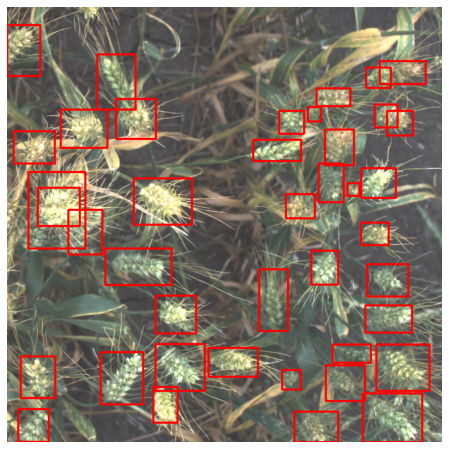

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## Train

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2
torch.cuda.empty_cache()

In [24]:
torch.cuda.empty_cache()

In [25]:
loss_hist = Averager()
itr = 2

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_dataloader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

/opt/conda/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Iteration #50 loss: 0.9353898763656616
Iteration #100 loss: 1.098941445350647
Iteration #150 loss: 0.9575412273406982
Iteration #200 loss: 0.835063636302948
Iteration #250 loss: 0.7348431348800659
Iteration #300 loss: 0.7886946797370911
Epoch #0 loss: 0.9650640088548351
Iteration #350 loss: 0.897838830947876
Iteration #400 loss: 0.8700713515281677
Iteration #450 loss: 0.9720749855041504
Iteration #500 loss: 0.7468106746673584
Iteration #550 loss: 0.7331332564353943
Iteration #600 loss: 0.6893053650856018
Iteration #650 loss: 0.8149735927581787
Epoch #1 loss: 0.8529056801205188


Now for Validation

In [26]:

images, targets, image_ids = next(iter(valid_dataloader))

In [27]:
             
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [28]:


boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [29]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

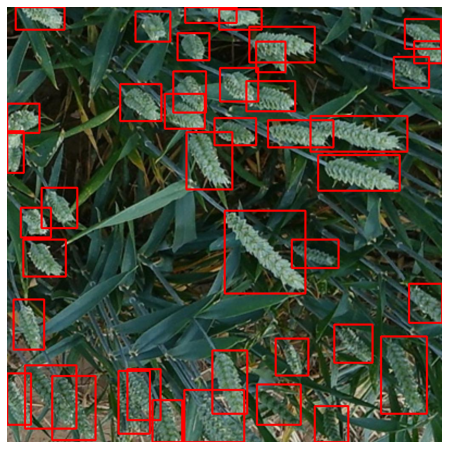

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [31]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')